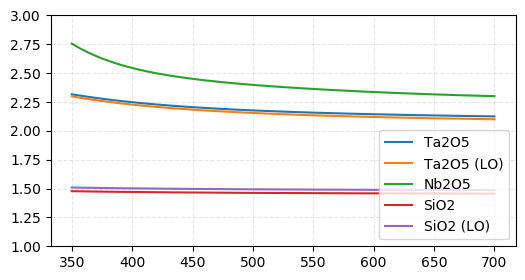

In [84]:
# Refractive indices
function n_refr(material::String, λ::Float64)
    """
    SiO2: https://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson
    Ta2O5: https://refractiveindex.info/?shelf=main&book=Ta2O5&page=Gao
    """
    λ /= 1000 # nm to μm
    if material == "SiO2"
        B = [0.6961663, 0.4079426, 0.8974794]
        C = [0.0684043, 0.1162414, 9.8961610]
        return √(1 + sum(B[i]*λ^2/(λ^2-C[i]^2) for i in 1:3)) # note: C[i]²
    elseif material == "Ta2O5" # values empiric from fit (exponential + polynomial) to data
        return 6.70419*exp(-11.1521*λ) + 2.27472 - 0.319763*λ + 0.144455*λ^2
    elseif material == "Nb2O5" # values empiric from fit (exponential + polynomial) to data, only valid between 400...800nm
        return 582.098*exp(-22.1463*λ) + 2.94173+ -1.58087*λ + 0.948068*λ^2
    else
        return 1.0
    end
end
# # # # # # # # # # # # # # # # # # # # # # # # # # # # 
function n_refr_LO(material::String, λ::Float64)
    """ Refractive index values from Laseroptik """
    λ /= 1000 # nm to μm
    B, C = zeros(Float64, 3), zeros(Float64, 3);
    if material == "SiO2" 
        B .= [1.19261271,   0.5415, 0]
        C .= [0.0079968567, 61.257, 0]
    elseif material == "Ta2O5"
        B .= [2.63437,   0.5694, 0.243937]
        C .= [0.0355851, 0,      81]
    elseif material == "NBK7"
        B .= [1.03961212,    0.231792344,  1.01046945]
        C .= [0.00600069867, 0.0200179144, 103.560653]
    else
        return 1.0
    end
    # Sellmeier formular: n² - 1 = sum(Bλ²/(λ²-C))
    return √(1 + sum(b*λ^2/(λ^2-c) for (b, c) in zip(B, C))) # note: c=C[i] without ²
end

using PyPlot
λ = 350:1.0:700
PyPlot.figure(figsize=(6, 3))
PyPlot.plot(λ, [n_refr("Ta2O5", wlen) for wlen in λ],    label="Ta2O5")
PyPlot.plot(λ, [n_refr_LO("Ta2O5", wlen) for wlen in λ], label="Ta2O5 (LO)")
PyPlot.plot(λ, [n_refr("Nb2O5", wlen) for wlen in λ],    label="Nb2O5")
PyPlot.plot(λ, [n_refr("SiO2", wlen) for wlen in λ],     label="SiO2")
PyPlot.plot(λ, [n_refr_LO("SiO2", wlen) for wlen in λ],  label="SiO2 (LO)")
PyPlot.ylim(1, 3)
PyPlot.grid(ls="--", alpha=0.3)
PyPlot.legend(loc=4);

In [22]:
# See also: Open-Filters Paper DOI: 10.1364/AO.47.00C219
function ReflectivityOfDielectricMirror(λ::AbstractFloat, λ₀::AbstractFloat, θ₀::AbstractFloat = 0.0, N::Int = 19)
    θ₀ = deg2rad(θ₀)
    # n₀: Medium(e.g. Ethyl. Glyc.), ns: Substrate, Material-1, Material-2
    n₀, ns, n₁, n₂ = 1.43, 1.51, n_refr_LO("Ta2O5", λ*1e9), n_refr_LO("SiO2", λ*1e9)
    n = vcat(repeat([n₁, n₂], N), n₁) # Layers. First and last material is identical
    # 
    θ = asin.(n₀ ./ n  * sin(θ₀)) # propagation angle inside the layers
    θ_out = asin(n₀/ns * sin(θ₀))
    # 
    ΔL = λ₀ ./ 4n # Thickness: λ/4
    k = 2π/λ .* n
    δ = k.*ΔL .* cos.(θ) # phase shift per layer
    # pseudo-indices
    η₀_s, ηs_s, η_s = n₀ * cos(θ₀), ns * cos(θ_out), n .* cos.(θ)
    η₀_p, ηs_p, η_p = n₀ / cos(θ₀), ns / cos(θ_out), n ./ cos.(θ) 
    # Transfer-Matrix-Generators for s- and p-pol. 
    M_s, M_p = ((
        [ cos(δₓ)         1im*sin(δₓ)/ηₓ;
          1im*sin(δₓ)*ηₓ  cos(δₓ)          ] for (δₓ, ηₓ) in zip(δ, η)
                                           ) for η in (η_s, η_p)        )
    # Calculation for s- and p-pol.
    v₁_s, v₂_s = [η₀_s -1; η₀_s 1] * prod(M_s) * [1, ηs_s]
    R_s = abs2(v₁_s/v₂_s)
    #
    v₁_p, v₂_p = [η₀_p -1; η₀_p 1] * prod(M_p) * [1, ηs_p]
    R_p = abs2(v₁_p/v₂_p)
    
#     for (η₀, ηs, η) in [(η₀_s, ηs_s, η_s), (η₀_p, ηs_p, η_p)]
#         M = ([ cos(δₓ)         1im*sin(δₓ)/ηₓ;
#                1im*sin(δₓ)*ηₓ  cos(δₓ)          ] for (δₓ, ηₓ) in zip(δ, η))
#         v₁, v₂ = [η₀ -1; η₀ 1] * prod(M) * [1, ηs]
#         R = abs2(v₁/v₂)
#     end
    #
    R_s, R_p
end

ReflectivityOfDielectricMirror (generic function with 3 methods)

In [53]:
# using Distributed
λ_ = 400.0 : 1.0 : 700.0
λ₀ = 550.0
θ_ = 0.0 : 1 : 90.0
R_raw = [ReflectivityOfDielectricMirror(λ*1e-9, λ₀*1e-9, θ) for θ in θ_, λ in λ_]
# R = pmap((θ, λ) -> ReflectivityOfDielectricMirrorLaseroptik(λ*1e-9, λ₀*1e-9, θ), (θ for θ=θ_, λ=λ_), (λ for θ=θ_, λ=λ_))
R_s, R_p = [r[1] for r in R_raw], [r[2] for r in R_raw] #  s- and p-polarization
T_s, T_p = 1 .- R_s, 1 .- R_p
T = (T_s + T_p)/2 # Transmission
size(R_raw), size(R_s)

((91, 301), (91, 301))

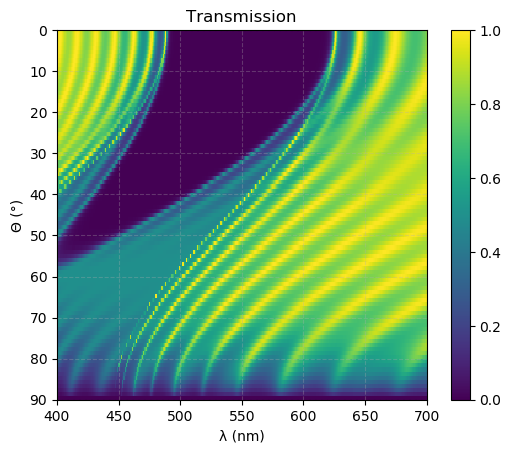

In [54]:
using PyPlot
PyPlot.imshow(T,
    extent = (extrema(λ_)..., reverse(extrema(θ_))...),
    aspect = -(extrema(λ_)...)/-(extrema(θ_)...),
    vmin = 0, vmax = 1
)
PyPlot.colorbar()
PyPlot.title("Transmission")
PyPlot.xlabel("λ (nm)")
PyPlot.ylabel("Θ (°)")
PyPlot.grid(ls="--", alpha=0.3)

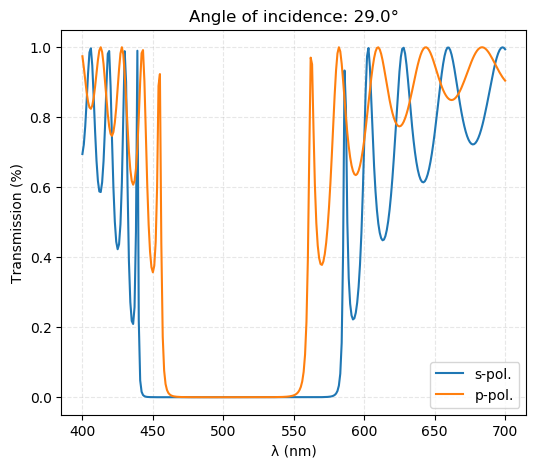

In [80]:
using PyPlot
PyPlot.figure(figsize=(6, 5))
angle_idx = 30
PyPlot.plot(λ_, T_s[angle_idx, :], label="s-pol.")
PyPlot.plot(λ_, T_p[angle_idx, :], label="p-pol.")
PyPlot.title(string("Angle of incidence: ", θ_[angle_idx], "°"))
PyPlot.xlabel("λ (nm)")
PyPlot.ylabel("Transmission (%)")
PyPlot.grid(ls="--", alpha=0.3)
PyPlot.legend();

In [56]:
# Write values to file
# using Printf
# f = open("Transmission_LosGatos580_Simulation_Erik.dat", "w")
# write(f, "# Materials: Nb2O5 and SiO2\r\n# Center wavelength: 585nm\r\n# 19 Stacks + 1\r\n#\r\n")
# for (i, angle) in enumerate(θ_)
#     write(f, string("# Angle of incidence ", angle, "°\r\n"))
#     write(f, "# wlen\tTs\t\t\t\tTp\r\n")
#     for (wlen, ts, tp) in zip(λ_, T_s[i, :], T_p[i, :])
#         write(f, string(wlen, "\t", @sprintf("%e", ts), "\t", @sprintf("%e", tp), "\r\n"))
#     end
# end
# close(f)

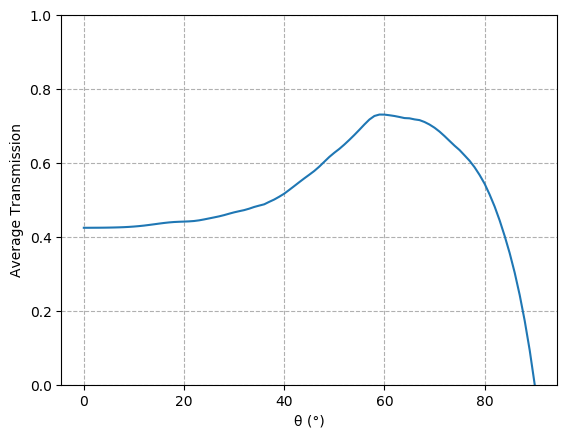

PyObject Text(24.000000000000007, 0.5, 'Average Transmission')

In [85]:
using PyPlot
using Statistics
PyPlot.plot(θ_, reshape(mean(T, dims=2), length(θ_))) # dims=1: vertical, 2: horizontal, reshape because otherwise it's a 1xN Matrix...
PyPlot.ylim(0, 1)
PyPlot.grid(ls="--")
PyPlot.xlabel("θ (°)")
PyPlot.ylabel("Average Transmission")

In [43]:
using DelimitedFiles
#writedlm("T_550_585.dat", [θ_ reshape(mean(T, dims=2), length(θ_))])